In [68]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from random import randrange
import threading
import time
import numpy as np
import pandas as pd
from datetime import datetime
import serial
import tkinter as tk
import time
import ipywidgets as widgets

In [94]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from random import randrange
import threading
import time
import numpy as np
import pandas as pd
from datetime import datetime
import serial
import tkinter as tk
import time
import ipywidgets as widgets
class LiveGraph:
    def __init__(self, port_name='/dev/cu.usbmodem145201', filename=None, 
                 host_sync=True, hot_temp=42.0, cold_temp=30.0, 
                 period_sec=1200.0, hot_duration_sec=600.0, send_interval_sec=0.5):
        # --- Logging/file ---
        self.filename = filename

        # --- Host-driving settings ---
        self.host_sync = bool(host_sync)
        self.hot_temp = float(hot_temp)
        self.cold_temp = float(cold_temp)
        self.period_sec = float(period_sec)
        self.hot_duration_sec = float(hot_duration_sec)
        self.cold_duration_sec = self.period_sec - self.hot_duration_sec
        self.send_interval_sec = float(send_interval_sec)
        self.start_epoch = time.time()
        phase = (time.time() - self.start_epoch) % self.period_sec
        self._last_host_target = self.hot_temp if phase < self.hot_duration_sec else self.cold_temp
        self._stop_event = threading.Event()

        # --- Dataframe ---
        columns = ["Real_time", "Serial_time", "Current_temp", "Target_temp",
                   "Heating_output", "Temp_diff", "Is_Heating"]
        self.df = pd.DataFrame(columns=columns)
        self.maxRows = 6000

        # --- Widgets ---
        self.button = widgets.Button(description="STOP!")
        self.output = widgets.Output()
        self.break_cycle = False
        self.button.on_click(self.on_button_clicked)

        self.text_input = widgets.Text(description="Send to Arduino:")
        self.text_input.on_submit(self.on_text_submit)

        # --- Plot ---
        self.figure, self.axes = plt.subplots(3)
        self.lines = []
        self.texts = []
        color = ['b', 'r', 'b', 'b']
        self.coli = ["Target_temp", "Current_temp", "Temp_diff", "Heating_output", "Is_Heating"]
        for i, n, c in zip([0, 0, 1, 2], self.coli, color):
            line, = self.axes[i].plot_date([], [], c, label=n, ls='-', marker='None')
            self.lines.append(line)
            text = self.axes[i].text(0, 0, ' ', color=c)
            self.texts.append(text)
        for ax in self.axes:
            ax.legend(loc="upper left")

        # --- Serial ---
        self.port = port_name
        self.ser = serial.Serial(self.port, 9600, timeout=1.3)
        time.sleep(2)
        self.ser.flush()

        # --- Animation ---
        self.animation = FuncAnimation(self.figure, self.update, interval=1000, cache_frame_data=False)

        # --- Reader thread ---
        self.th = threading.Thread(target=self.thread_f, daemon=True)
        self.th.start()

        # --- Host-sync thread ---
        if self.host_sync:
            self._sync_thread = threading.Thread(target=self._host_sync_loop, daemon=True)
            self._sync_thread.start()

    # Background loop that drives Arduino setpoints based on host clock
    def _host_sync_loop(self):
        while not self._stop_event.is_set():
            phase = (time.time() - self.start_epoch) % self.period_sec
            target = self.hot_temp if phase < self.hot_duration_sec else self.cold_temp

            try:
                self.ser.write(f"{int(round(target))}\n".encode())
                self._last_host_target = target

                epsilon = 0.25
                near_hot_cold = (abs(phase - self.hot_duration_sec) < epsilon) or (abs(phase - self.period_sec) < epsilon)
                if near_hot_cold:
                    time.sleep(0.05)
                    self.ser.write(f"{int(round(target))}\n".encode())

            except Exception as e:
                print("Serial write failed in host loop:", e)
                time.sleep(0.1)

            time.sleep(self.send_interval_sec)

    # --- Plot updater ---
    def update(self, frame):
        if len(self.df) > 0:
            for (li, te, col) in zip(self.lines, self.texts, self.coli):
                li.set_data(self.df['Real_time'], self.df[col])
                try:
                    te.set_position((self.df['Real_time'].iloc[-1], self.df[col].iloc[-1]))
                    te.set_text(round(float(self.df[col].iloc[-1]), 2))
                except Exception:
                    pass
            for ax in self.axes:
                ax.relim()
                ax.autoscale_view()

        if self.break_cycle:
            self.animation.event_source.stop()
        return self.lines

    # --- STOP button handler ---
    def on_button_clicked(self, event):
        print("Button pressed: break_cycle:", self.break_cycle)
        self.break_cycle = True
        try:
            self._stop_event.set()
            self.ser.close()
        except Exception:
            pass

    # --- Text input to Arduino ---
    def on_text_submit(self, text_widget):
        value = text_widget.value
        print(f"Sending to Arduino: {value}")
        try:
            self.ser.write((value + '\n').encode())
        except Exception as e:
            print("Serial write failed:", e)
        text_widget.value = ""

    # --- Show UI ---
    def show(self):
        plt.show()
        display(self.button, self.text_input, self.output)

    # --- Serial reader ---
    def thread_f(self):
        while not self.break_cycle:
            line = self.ser.readline().decode(errors='ignore').strip()
            nums = line.split()
            if len(nums) == 5:
                try:
                    values = [float(num) for num in nums[0:4]]
                    arduino_millis = values[0]
                    curr_temp      = values[1]
                    arduino_target = values[2]
                    heater_output  = values[3]
                    is_heating     = nums[4]

                    if self.host_sync and (self._last_host_target is not None):
                        host_target = float(self._last_host_target)
                    else:
                        host_target = arduino_target

                    temp_df = pd.DataFrame({
                        "Real_time":       [pd.Timestamp.now()],
                        "Serial_time":     [arduino_millis / 1000.0],
                        "Current_temp":    [curr_temp],
                        "Target_temp":     [host_target],
                        "Heating_output":  [heater_output],
                        "Temp_diff":       [curr_temp - host_target],
                        "Is_Heating":      [is_heating],
                        "Arduino_Target":  [arduino_target],
                        "Host_Target":     [host_target],
                    })

                    self.df = pd.concat([self.df, temp_df], ignore_index=True)
                    if self.filename is not None:
                        temp_df.to_csv(self.filename, mode='a',
                                       header=not os.path.exists(self.filename), index=False)
                    if len(self.df) > self.maxRows:
                        self.df = self.df.tail(self.maxRows)

                except Exception as err:
                    print(f"Unexpected {err=}, {type(err)=}")
                    print(f"The serial out put is {line=}")

            time.sleep(0.001)






# Running the program


/var/folders/1z/90h8gx3n6tb7kp5_zfqsbkv00000gn/T/ipykernel_39253/1818729612.py:47: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  self.text_input.on_submit(self.on_text_submit)
/var/folders/1z/90h8gx3n6tb7kp5_zfqsbkv00000gn/T/ipykernel_39253/1818729612.py:56: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  line, = self.axes[i].plot_date([], [], c, label=n, ls='-', marker='None')
/var/folders/1z/90h8gx3n6tb7kp5_zfqsbkv00000gn/T/ipykernel_39253/1818729612.py:177: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([s

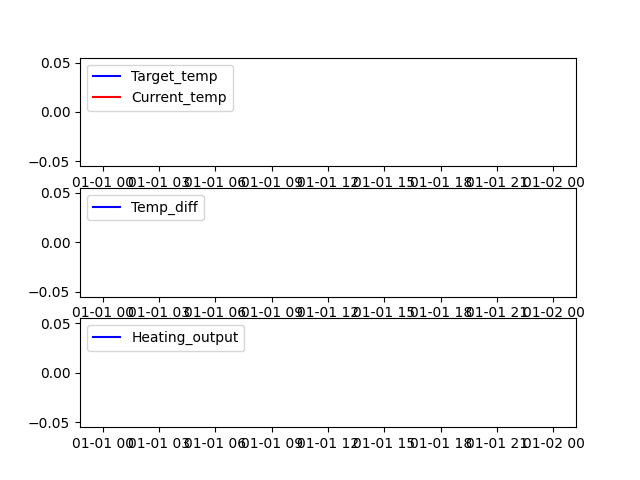

Button(description='STOP!', style=ButtonStyle())

Text(value='', description='Send to Arduino:')

Output()

Exception in thread Thread-85:
Traceback (most recent call last):
  File "/Users/joshuabeard/Library/Python/3.9/lib/python/site-packages/serial/serialposix.py", line 565, in read
    ready, _, _ = select.select([self.fd, self.pipe_abort_read_r], [], [], timeout.time_left())
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/joshuabeard/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/1z/90h8gx3n6tb7kp5_zfqsbkv00000gn/T/ipykernel_39253/18

In [95]:
g = LiveGraph(filename = "2025_8_15.csv")
g.show()

# Save your results!

In [ ]:
g.df.to_csv(r'C:\Users\Wiggi\Desktop\James\temp_data\1_10_2025.csv')

In [ ]:
%pip install pyserial pandas numpy matplotlib ipywidgets


In [ ]:
import serial, serial.tools.list_ports

# get all ports
ports = serial.tools.list_ports.comports()
port_list = [port.device for port in ports]
print("Available ports:", port_list)

# open the first available port (if any)
if port_list:
    ser = serial.Serial(port_list[0], 9600, timeout=1.3)
    print("Opened:", ser.port)
else:
    print("No serial ports found!")
  


In [ ]:
serial.Serial('/dev/cu.usbmodem145301', 9600, timeout=1.3)

In [ ]:
import serial.tools.list_ports
print(list(serial.tools.list_ports.comports()))